(12, 49, 193, 61)


<xarray.DataArray 'T' (T: 12)> Size: 96B
array(['1969-02-14T16:30:00.000000000', '1969-03-17T03:00:00.000000000',
       '1969-04-16T13:30:00.000000000', '1969-05-17T00:00:00.000000000',
       '1969-06-16T10:30:00.000000000', '1969-07-16T21:00:00.000000000',
       '1969-08-16T07:30:00.000000000', '1969-09-15T18:00:00.000000000',
       '1969-10-16T04:30:00.000000000', '1969-11-15T15:00:00.000000000',
       '1969-12-16T01:30:00.000000000', '1970-01-15T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * T        (T) datetime64[ns] 96B 1969-02-14T16:30:00 ... 1970-01-15T12:00:00
Attributes:
    long_name:  model_time

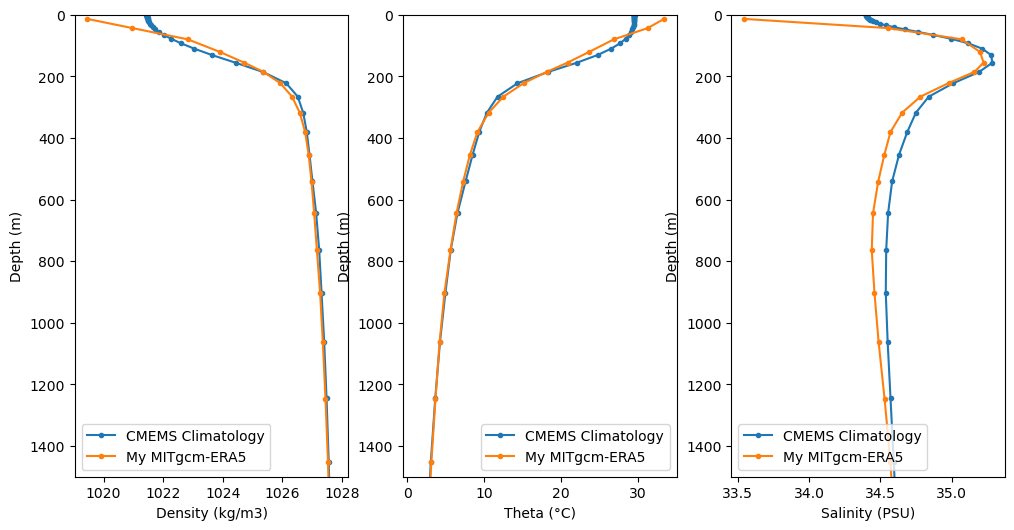

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
path = '../../data/'
pclim = path+'cmems_climatology_mon.nc'
path = '../output/251119/'
pgrid = path+'grid.nc'
pdync = path+'dync.nc'
tl,zl,yl,xl = slice(None),slice(-1),slice(-8,8),slice(155,160)

with xr.open_dataset(pclim) as clim:
    t = clim['thetao'][tl,zl].loc[:,:,yl,xl]
    s = clim['so'][tl,zl].loc[:,:,yl,xl]
    print(t.shape)
    to = t.mean(['time','latitude','longitude']).values
    so = s.mean(['time','latitude','longitude']).values
    dep = clim['depth'][zl].values
    dr = np.zeros(dep.shape)
    lev = 0
    for i in range(dep.size):
        dr[i] = 2*(dep[i]-lev)
        lev += dr[i]
pdo = sw.dens0(so,to)

with xr.open_dataset(pgrid) as grid:
    z = -grid['Z'].values
    dz = grid['Zl'].values-grid['Zu'].values
i = 29
tl,zl = slice(-12,None),slice(None)
with xr.open_dataset(pdync) as dync:
    display(dync['THETA'][tl]['T'])
    t = dync['THETA'][tl].loc[:,zl,yl,xl]
    s = dync['SALT'][tl].loc[:,zl,yl,xl]
    t,s = t.where(t), s.where(s)
    t = t.mean(['T','Y','X']).values
    s = s.mean(['T','Y','X']).values
    u = dync['UVEL'][tl].loc[:,zl,yl,xl]
    x = u[u.dims[3]].values
    y = u[u.dims[2]].values
pd = sw.dens0(s,t)
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(pdo,dep,marker='.',label='CMEMS Climatology')
plt.plot(pd,z,marker='.',label='My MITgcm-ERA5')
plt.xlabel('Density (kg/m3)')
plt.ylabel('Depth (m)')
plt.ylim(1500,0)
plt.legend()
plt.subplot(132)
plt.plot(to,dep,marker='.',label='CMEMS Climatology')
plt.plot(t,z,marker='.',label='My MITgcm-ERA5')
plt.xlabel('Theta (°C)')
plt.ylabel('Depth (m)')
plt.ylim(1500,0)
plt.legend()
plt.subplot(133)
plt.plot(so,dep,marker='.',label='CMEMS Climatology')
plt.plot(s,z,marker='.',label='My MITgcm-ERA5')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Depth (m)')
plt.ylim(1500,0)
plt.legend()
plt.savefig(path+'profile.png',dpi=300)

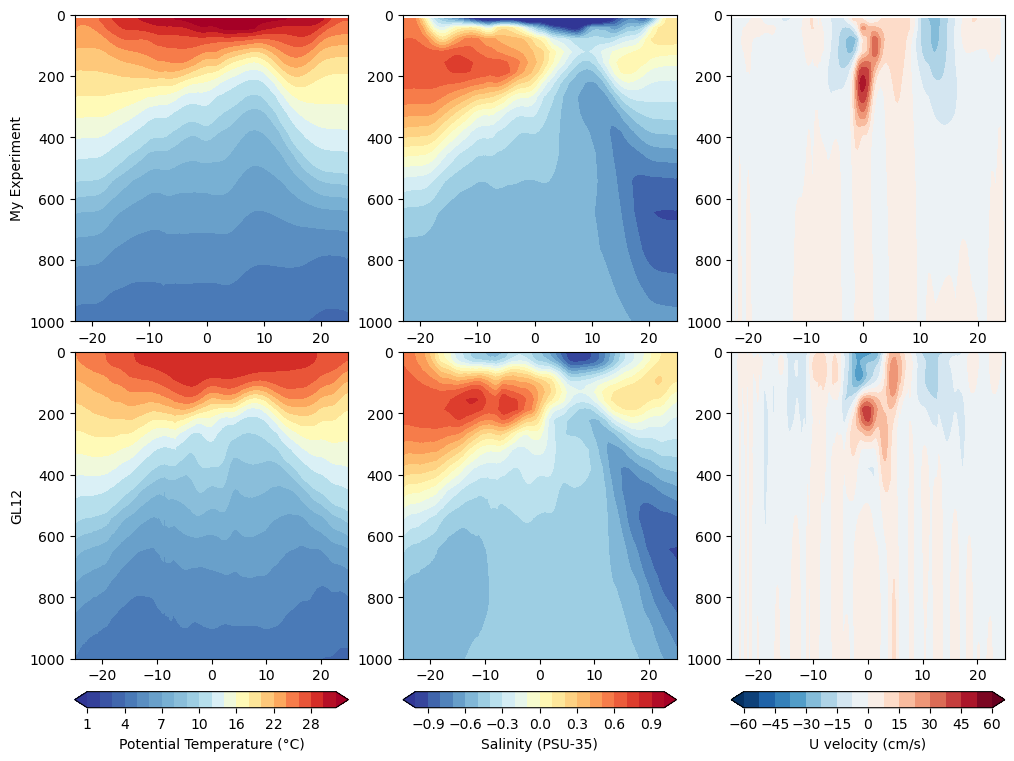

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
from dymodes import dymodes
path = '../../data/'
pclim = path+'cmems_climatology_mon.nc'
tl,zl,yl,xl = slice(None),slice(-1),slice(None,None),slice(155,160)
with xr.open_dataset(pclim) as clim:
    to = clim['thetao'][tl,zl].loc[:,:,yl,xl]
    so = clim['so'][tl,zl].loc[:,:,yl,xl]
    uo = clim['uo'][tl,zl].loc[:,:,yl,xl]
    xo = uo[uo.dims[3]].values
    yo = uo[uo.dims[2]].values
    zo = uo[uo.dims[1]].values
    to = to.mean(['time','longitude']).values
    so = so.mean(['time','longitude']).values
    uo = uo.mean(['time','longitude']).values

path = '../output/251119/'
tl,zl = slice(-12,None),slice(None)
with xr.open_dataset(path+'grid.nc') as grid:
    z = -grid['Z'].values
with xr.open_dataset(path+'dync.nc') as dync:
    t = dync['THETA'][tl].loc[:,zl,yl,xl]
    s = dync['SALT'][tl].loc[:,zl,yl,xl]
    u = dync['UVEL'][tl].loc[:,zl,yl,xl]
    x = u[u.dims[3]].values
    y = u[u.dims[2]].values
    t,s = t.where(t), s.where(s)
    u = u.where(u)
    t = t.mean(['T','X']).values
    s = s.mean(['T','X']).values
    u = u.mean(['T','Xp1']).values
ylim = [1000,0]
fg = plt.figure(figsize=(12,9))
gs = fg.add_gridspec(2,1,height_ratios=[2,0.05],hspace=0.1)
gsf = gs[0].subgridspec(2,3,hspace=0.1)
gsc = gs[1].subgridspec(1,3)

levels = np.concatenate((np.arange(1,10,1),np.arange(10,33,2)))
plt.subplot(gsf[0,0])
plt.contourf(y,z,t,levels,cmap='RdYlBu_r',extend='both')
plt.ylabel('My Experiment')
plt.ylim(ylim)
plt.subplot(gsf[1,0])
im = plt.contourf(yo,zo,to,levels,cmap='RdYlBu_r',extend='both')
plt.ylim(ylim)
plt.ylabel('GL12')
plt.colorbar(im,cax=plt.subplot(gsc[0]),orientation='horizontal',label='Potential Temperature (°C)')

levels = np.linspace(-1,1,21)
plt.subplot(gsf[0,1])
plt.contourf(y,z,s-35,levels,cmap='RdYlBu_r',extend='both')
plt.ylim(ylim)
plt.subplot(gsf[1,1])
im = plt.contourf(yo,zo,so-35,levels,cmap='RdYlBu_r',extend='both')
plt.ylim(ylim)
plt.colorbar(im,cax=plt.subplot(gsc[1]),orientation='horizontal',label='Salinity (PSU-35)')

levels = 60*np.linspace(-1,1,17)
plt.subplot(gsf[0,2])
plt.contourf(y,z,u*100,levels,cmap='RdBu_r',extend='both')
plt.ylim(ylim)
plt.subplot(gsf[1,2])
im = plt.contourf(yo,zo,uo*100,levels,cmap='RdBu_r',extend='both')
plt.ylim(ylim)
plt.colorbar(im,cax=plt.subplot(gsc[2]),orientation='horizontal',label='U velocity (cm/s)')
plt.savefig(path+'section.png',dpi=300)